In [ ]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Define Jaeger API URL
JAEGER_API_URL = "http://192.168.69.210:16686/api/traces"


# Define parameters for the query
service_name = 'compose-post-service'
start_check_time = datetime(2024, 7, 15, 17, 15,0)  # check_start_time
end_check_time = datetime(2024, 7, 15, 17, 35,0)  # check_end_time

limit = 1000

# Function to convert datetime to Unix timestamp in microseconds
def datetime_to_microseconds(dt):
    return int(dt.timestamp() * 1e6)

# Function to query Jaeger API
def query_jaeger(service_name, start_time, end_time, limit):
    params = {
        "service": service_name,
        "start": datetime_to_microseconds(start_time),
        "end": datetime_to_microseconds(end_time),
        "limit": limit
    }
    response = requests.get(JAEGER_API_URL, params=params)
    response.raise_for_status()
    return response.json()

# Parse the trace data
def parse_jaeger_data(data):
    traces = data['data']
    trace_list = []
    for trace in traces:
        trace_id = trace['traceID']
        for span in trace['spans']:
            operation = span['operationName']
            start_time = datetime.utcfromtimestamp(span['startTime'] / 1e6)
            duration = span['duration'] / 1e3  # Convert microseconds to milliseconds
            trace_list.append({
                "trace_id": trace_id,
                "operation": operation,
                "start_time": start_time,
                "duration": duration
            })
    return pd.DataFrame(trace_list)

# Fetch trace data from Jaeger
data = query_jaeger(service_name, start_check_time, end_check_time, limit)

# Parse the data into a DataFrame
df = parse_jaeger_data(data)

# Convert 'start_time' to datetime and 'duration' to numeric
df['start_time'] = pd.to_datetime(df['start_time'])

# Save DataFrame to CSV
df.to_csv('k8s_composePost.csv')


In [6]:

df



,trace_id,operation,start_time,duration
0,04b1f830c1dfdb41,compose_urls_client,2024-07-15 06:42:28.930919,50.105
1,04b1f830c1dfdb41,compose_user_mentions_client,2024-07-15 06:42:28.930919,88.690
2,04b1f830c1dfdb41,compose_text_server,2024-07-15 06:42:28.930670,89.054
3,04b1f830c1dfdb41,get_followers_client,2024-07-15 06:42:29.190638,102.533
4,04b1f830c1dfdb41,write_home_timeline_redis_update_client,2024-07-15 06:42:29.293190,14.411
...,...,...,...,...
32907,1660cc4777306a23,url_mongo_insert_client,2024-07-15 07:31:35.665774,14.215
32908,1660cc4777306a23,compose_creator_server,2024-07-15 07:31:35.675852,0.004
32909,1660cc4777306a23,write_user_timeline_mongo_insert_client,2024-07-15 07:31:35.798659,41.627
32910,1660cc4777306a23,write_user_timeline_redis_update_client,2024-07-15 07:31:35.840330,917.401


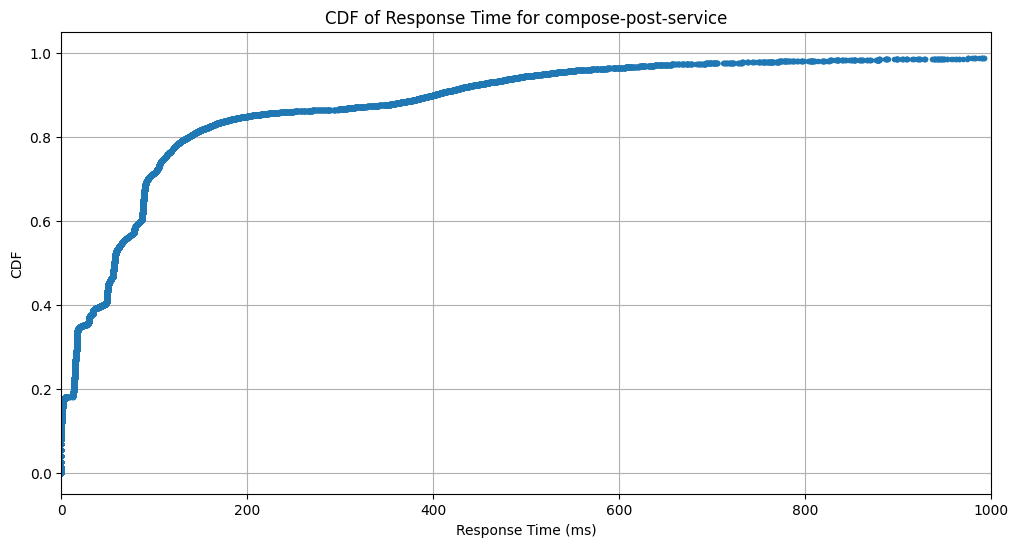

In [8]:

# Check if data is available
if df.empty:
    print("No trace data found.")
else:
    # Convert start_time to datetime for time-based grouping
    
    # Ensure 'duration' column is numeric
    df['duration'] = pd.to_numeric(df['duration'], errors='coerce')
    
    # Drop rows with NaN values in 'duration'
    df = df.dropna(subset=['duration'])

    # Sort the duration values
    sorted_duration = df['duration'].sort_values()

    # Calculate CDF values
    cdf = sorted_duration.rank(method='average', pct=True)

    # Plot the CDF
    plt.figure(figsize=(12, 6))
    plt.plot(sorted_duration, cdf, marker='.', linestyle='none')
    plt.title('CDF of Response Time for compose-post-service')
    plt.xlim(0,1000)
    plt.xlabel('Response Time (ms)')
    plt.ylabel('CDF')
    plt.grid(True)
    plt.show()
